# Calculus and Backprop

> We need some principles from calculus and linear algebra

Adapted from:
- https://youtu.be/_xIzPbCgutY?si=_j757wC5ed44lDk7
- https://youtu.be/vGdB4eI4KBs?si=oRxdtJTpa-MvxaPQ

In [1]:
#| default_exp calculus

In [2]:
# |export
from dataclasses import dataclass
from typing import Any

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import sympy
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from einops import einsum, rearrange
from torch import nn
from torch.utils.data import DataLoader

from slowai.overview import show_image

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The better calculus pedagogy is the calculus of infintesimals, that is: assume $f'(x) = \frac{f(x + \Delta x)-f(x)}{\Delta x}$ like normal and ignore second order infinitesimals (i.e., infinitesimals of infinitesimals). By doing so, the main rules of arithmetic suddenly also apply to calculus. For example:

### Power Rule

$$
\begin{align*} 
\frac{\Delta}{\Delta x} x^2 & = \frac{(x + \Delta x)^2 - x^2}{\Delta x} \\
	& = \frac{x^2 + 2 x \Delta x + \Delta x^2 - x^2}{\Delta x} \\
	& = \frac{2 x \Delta x + \Delta x^2}{\Delta x} \\
	& = \frac{2 x \Delta x}{\Delta x} \\
	& = 2x
\end{align*}
$$

(Fundamental theorem, commutativity, cancelling terms in numerator, second rule, cancelling shared term in numerator and denominator.)

### Chain Rule

$$
\begin{align*} 
\frac{\Delta y}{\Delta x} = \frac{\Delta y}{\Delta u} \left( \frac{\Delta u}{\Delta x} \right)
\end{align*}
$$

(Shared term in numerator and denominator.) 

This is simple arithmetic! For a geometric interpretation, imagine a conveyer belt system, where a motor is connected to A, pulling B and C.  Suppose A has a circumference twice of B, and B twice of C. The rate of rotation of C is $2 \times 2=4$X that of A.

![](../images/conveyer_belt.png)

This corresponds to the system of equations:

$$
\begin{align}
\frac{\delta C}{\delta B} &= 2\\
\frac{\delta B}{\delta A} &= 2\\
\therefore \frac{\delta C}{\delta A} &= \frac{\delta C}{\delta B} \left( \frac{\delta B}{\delta A} \right) = 2 \times 2 =4 \\
\end{align}
$$

If these functions were non-linear, imagine the circumferences of these "functions" changing.

### Gradient of a linear layer

Suppose we had a loss function $\mathcal{L=l(n(W, x))}$ for some $l$, and $n(W, x)=Wx$. What is $\frac{\delta L}{\delta W}$?

$$
\frac{\delta L}{\delta W} = \frac{\delta L}{\delta n(W, x)} \left( \frac{\delta n(W, x)}{\delta W} \right)
$$

In English, the gradient of the loss with respect to the parameter $W$ is the product of the gradient of the loss with respect of the output of the neural network and the gradient of the output of the neural network with respect to $W$.

In an autograd framework, the gradient of the loss with respect of the output of the neural network is given by evaluating the derivative of the downstream layer.

Note that $\frac{\delta n(W, x)}{\delta W}$ is $W^T$

![](../images/matrix_derivative.jpg)

## Neural Networks

Suppose we wanted to model this function with a neural network.

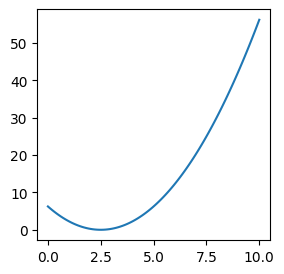

In [3]:
x = np.linspace(0, 10, 100)
y = (x - 2.5) ** 2
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(x, y);

A single line wouldn't be especially adequate for this. (The sum of lines is just a line.) But what about the sum of rectified lines?

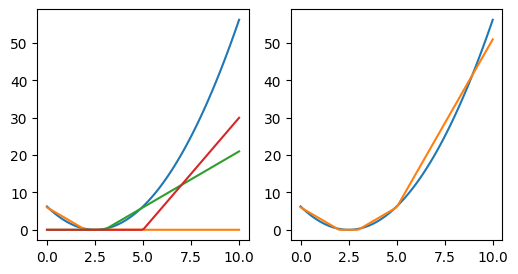

In [4]:
y1 = np.clip(-3 * (x - 2), a_min=0, a_max=None)
y2 = np.clip(3 * (x - 3), a_min=0, a_max=None)
y3 = np.clip(6 * (x - 5), a_min=0, a_max=None)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6, 3))
ax0.plot(x, y)
ax0.plot(x, y1)
ax0.plot(x, y2)
ax0.plot(x, y3)
ax1.plot(x, y)
ax1.plot(x, y1 + y2 + y3);

This is the idea of neural networks (except, instead of lines, we're dealing with hyperplanes).

### Basic architecture

Let's consider a specific problem. Suppose we wanted to classify digits with a simple neural network.

In [5]:
# |export
class MNISTDataModule(L.LightningDataModule):
    def __init__(self, bs=128):
        super().__init__()
        self.bs = bs

    def setup(self, stage=None):
        transform = transforms.Compose([transforms.ToTensor()])
        self.trn = torchvision.datasets.MNIST(
            root="./data",
            train=True,
            transform=transform,
            download=True,
        )
        self.tst = torchvision.datasets.MNIST(
            root="./data",
            train=False,
            transform=transform,
            download=True,
        )

    def train_dataloader(self):
        return DataLoader(
            self.trn,
            batch_size=self.bs,
            shuffle=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.tst,
            batch_size=self.bs,
            shuffle=False,
        )

    def as_matrix(self, split):
        data = dm.trn if split == "trn" else dm.tst
        xs, ys = zip(*data)
        xs = torch.stack(xs).squeeze()
        ys = torch.tensor(ys)
        return xs, ys

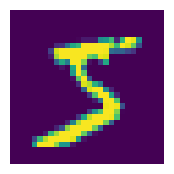

In [6]:
dm = MNISTDataModule()
dm.setup()
X_trn, Y = dm.as_matrix("trn")

X_trn = X_trn.numpy()
Y = y_true = Y.numpy()

show_image(X_trn[0, ...].squeeze())

It's a bit cleaner to deal with images as vectors for this exercise.

In [7]:
X_trn = rearrange(X_trn, "b h w -> b (h w)")

Say we wanted to classify a digit as a "seven" (or not) based on a single pixel. A trained linear model would find some coefficient and you would draw some line dividing sevens from non-sevens.

Of course, this is pretty limiting. What if this surface had a lot of curvature?

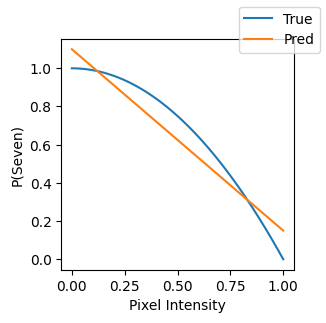

In [8]:
x = np.linspace(0, 1, 100)
y_t = 1 - x**2
y_pred = -0.95 * x + 1.1
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(x, y_t, label="True")
ax.plot(x, y_pred, label="Pred")
ax.set(xlabel="Pixel Intensity", ylabel="P(Seven)")
fig.legend();

How do fit the sum of rectified lines like before?

To make this more interesting, let's consider using all pixels, for all images.

Let's define some parameters and helpers.

In [9]:
def relu(x):
    return np.clip(x, a_min=0, a_max=None)


n, m = X_trn.shape
nh = 50  # num. hidden dimensions
n, m

(60000, 784)

Our results are going to be non-sense here, but this gives us the right dimensions for everything.

In [10]:
W0 = np.random.randn(m, nh)
b0 = np.zeros(nh)
W1 = np.random.randn(nh, 1)
b1 = np.zeros(1)

l0 = X_trn @ W0 + b0
l1 = relu(l0)
y_pred = l1 @ W1 + b1
y_pred[:5]

array([[ 6.8289726 ],
       [72.09719876],
       [18.86550253],
       [48.51077387],
       [26.31364366]])

Let's compute an regression loss to get the model to predict the label. (This isn't formally apropriate but it gives us the intuition.)

In [11]:
y_pred.shape, y_true.shape

((60000, 1), (60000,))

In [12]:
diff = y_pred.T - y_true
mse = (diff**2).mean()
mse

1202.3874693857676

Eventually, at the end of the forward pass, we end up with a **single number**. We generally compute the loss for each example in the batch and take the batchwise mean or sum.

So, what do we do with this? Well, we want the gradient with respect to each of these numbers, so: $\frac{\delta loss}{\delta W_0}, \frac{\delta loss}{\delta b_0}, \frac{\delta loss}{\delta W_1}$ and $\frac{\delta loss}{\delta b_1}$

Note that the $\delta$ here is specific to the multivariate context indicating the change of $loss$ with respect to all dimensions of the tensor. For example:

$$
\frac{\delta loss}{\delta W_0} =
  \begin{bmatrix}
    \frac{\Delta loss}{\Delta w_0} & ... & \frac{\Delta loss}{\Delta w_{784}} \\
  \end{bmatrix}
$$

Or, for $W1$ where ($U = x W_1$)

$$
\frac{\delta U}{\delta W_1} =
  \begin{bmatrix}
    \frac{\Delta U_{0,0}}{\Delta w_{0,0}} & ... & \frac{\Delta U_{0,j}}{\Delta w_{0,j}} \\
                              \vdots  & \ddots & \vdots \\
    \frac{\Delta U_{i,0}}{\Delta w_{i,0}} & ... & \frac{\Delta U_{i,j}}{\Delta w_{i,j}} \\
  \end{bmatrix}
$$

This is known as a Jacobian.

Let's calculate all the derivates.

Starting with MSE. By the chain rule:

$$
\frac{d}{dx} f(g(x,y)) = f'(g(x,y)) g'(x,y)
$$

Let $g(x,y) = x-y$ and $f(x) = \frac{x^2}{n}$

Thus, $\frac{d}{dx} g(x,y)=\frac{dx}{dx} - \frac{dy}{dx}=1$ and $$
\begin{align*}
f'(g(x, y)) & = f'((x-y)^2 / n) \\
            & = f'((x^2 - 2xy + y^2)/n) \\
            & = (2x - 2y) / n 
\end{align*}
$$

Let's verify:

In [13]:
assert n == 60000
x, y = sympy.symbols("x y")
sympy.diff(((x - y) ** 2) / n, x)

x/30000 - y/30000

Great. Now, in code:

In [14]:
@dataclass
class T:
    """Wrapper for numpy arrays to help store a gradient"""

    value: Any
    g: Any = None

    def __getattr__(self, t):
        return getattr(self.value, t)

    def __getitem__(self, i):
        return self.value[i]

    @property
    def v(self):
        return self.value

In [15]:
def mse_grad(y_pred: T, y_true: np.array):
    """MSE=(y_pred-y_true)**2/n.

    By the chain rule, d/dx ( f(g(x,y)) ) = f'(g(x,y)) g'(x,y)

    Assume that y is a constant and let g(x,y) = x-y and f(x) = x**2 / n

    g'(x, y) = 1 and f'(g(x, y))
                   = f'((x-y)**2 / n)
                   = f'((x**2 - 2xy + y**2)/n)
                   = (2x - 2y) / n

    f'(g(x,y)) g'(x,y) =  [ 2(x - y) / n ] * 1 = 2(x - y) / n

    Therefore, dMSE/d_{y_pred} = 2 * (y_pred - y_true) / n."""
    diff = y_pred.squeeze() - y_true
    y_pred.g = (2 * diff / n)[:, None]

In [16]:
# "Tensorize" the weights, biases and outputs
tensors = (y_pred, W1, b1, l1, W0, b0, l0, X_trn)
ty_pred, tW1, tb1, tl1, tW0, tb0, tl0, tX_trn = map(T, tensors)
mse_grad(ty_pred, y_true)
ty_pred.g[:5]

array([[6.09657532e-05],
       [2.40323996e-03],
       [4.95516751e-04],
       [1.58369246e-03],
       [5.77121455e-04]])

Check out the derivation of the "Gradient of a linear layer" image for the derivation of the matrix derivative.

We'll return to the derivative of the bias term later.

In [17]:
ty_pred.g.shape

(60000, 1)

In [18]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.T
    w.g = einsum(inp.v, out.g, "bs ha, bs hb -> ha hb")
    b.g = out.g.sum(axis=0)

For ReLU, we pass the upstream gradient downstream for any dimensions that contributed to the upstream signal.

In [19]:
def relu_grad(inp, out):
    inp.g = (inp.value > 0).astype(float) * out.g

Putting it all together:

In [20]:
mse_grad(ty_pred, y_true)
lin_grad(tl1, ty_pred, tW1, tb1)
relu_grad(tl0, tl1)
lin_grad(tX_trn, tl0, tW0, tb0)

tW0.g.shape

(784, 50)

Verify with PyTorch

In [27]:
# Port layers
pt_lin0 = nn.Linear(m, nh)
dtype = pt_lin0.weight.data.dtype
pt_lin0.weight.data = torch.from_numpy(tW0.v.T).to(dtype)
pt_lin0.bias.data = torch.from_numpy(tb0.v).to(dtype)
pt_lin1 = nn.Linear(nh, 1)
pt_lin1.weight.data = torch.from_numpy(tW1.T).to(dtype)
pt_lin1.bias.data = torch.from_numpy(tb1.v).to(dtype)

# Forward pass
logits = pt_lin0(torch.from_numpy(X_trn).to(dtype))
logits = F.relu(logits)
logits = pt_lin1(logits)
loss = F.mse_loss(
    logits.squeeze(),
    torch.from_numpy(y_true).float(),
)

# Backward pass
loss.backward()


for w, b, layer in [
    (tW0, tb0, pt_lin0),
    (tW1, tb1, pt_lin1),
]:
    assert torch.isclose(
        torch.from_numpy(w.g.T).float(),
        layer.weight.grad,
        atol=1e-4,
    ).all()
    assert torch.isclose(
        torch.from_numpy(b.g.T).float(),
        layer.bias.grad,
        atol=1e-4,
    ).all()

Let's refactor these as a class.

In [25]:
@dataclass
class Module:
    # def __

    def __call__(self, x):
        self.inp = x
        self.out = self.forward(x)
        return self.out


class ReLu(Module):
    def forward(self, x: T):
        return relu(x)

    def backwards(self):
        relu_grad(self.inp, self.out)


@dataclass
class Linear(Module):
    W: T
    b: T

    # def

In [26]:
#| hide
import nbdev

nbdev.nbdev_export()